# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Напишите заголовок первой части проекта здесь

- Автор: Бурыкина Е.А.
- Дата: 08.05.2025 г.

## Цели и задачи проекта

<font color='#777778'>     
    
    Цель проекта - проанализировать данные пользователей из Москвы и Санкт-Петербурга с суммой часов их активности и провести А/В тест, подтверждающий или опровергающий гипотезу.      
    
    Задачи проекта - рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.  
    
    Особенность А/В теста - изменение ключевой метрики- среднее время активности пользователей в Санкт-петербурге и Москве.</font>

## Описание данных

<font color='#777778'>    
   Таблицы этого проекта содержат данные о чтении и прослушивании контента в сервисе Яндекс Книги.    
    
   - `city` -  город пользователя;    
    
   - `puid` - идентификатор пользователя;  
    
   - `hours` - длительность чтения или прослушивания в часах.</font>

## Содержимое проекта

<font color='#777778'> 
    
    Часть 1.  
    
    1. Загрузка данных и знакомство с ними. 
    
    2.Проверка гипотезы в Python.   
    
    3. Аналитическая записка.   
    
    Часть 2.    
    
    1.Анализ результатов А/В тестирования.   
    
    2.Описание цели проекта.  
    
    3.Загрузка данных.  
    
    4.Оценка корректности проведения теста.   
    
    5.Оценка результатов А/В тестирования.

---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [2]:
df = pd.read_csv('/datasets/yandex_knigi_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [3]:
print(f'Количество дубликатов:{df.duplicated().sum()}')
df.head()

Количество дубликатов:0


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
a = df.duplicated(subset=['puid']).sum() 
print (f'Количество дублирующих идентификаторов пользователей: {a}') 
user_ids = df[df.duplicated(subset=['puid'])]
x = 100 * len(user_ids) / df['puid'].nunique() 
print (f'Доля дублирующих идентификаторов пользователей от общего количество равно: {x:.2f}%')

Количество дублирующих идентификаторов пользователей: 244
Доля дублирующих идентификаторов пользователей от общего количество равно: 2.86%


In [5]:
df = df.drop_duplicates(['puid'])

###### Так как процент дублирующих идентификаторов мал и составляет всего 2 %, мы можем удалить их для чистоты данных.

In [6]:
df_grp = df.groupby('city').agg({'puid': 'nunique'}).reset_index()
df_grp

,city,puid
0,Москва,6234
1,Санкт-Петербург,2306


In [7]:
df['hours'].describe()

count    8540.000000
mean       10.984603
std        37.677623
min         0.000018
25%         0.059927
50%         0.909128
75%         5.970493
max       978.764775
Name: hours, dtype: float64

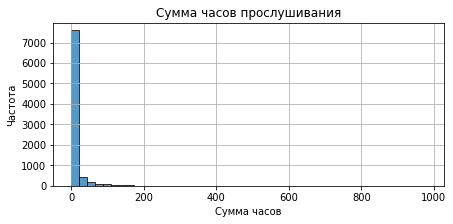

In [8]:
plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['hours'].plot(
                kind='hist', # Тип графика — гистограмма
                bins=45, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
)

# Настраиваем оформление графика
plt.title('Сумма часов прослушивания')
plt.xlabel('Сумма часов')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

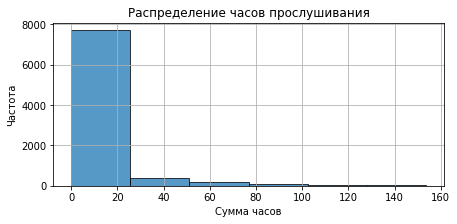

In [9]:
cleaned_page_counter = df[df['hours'] <= df['hours'].quantile(0.99)]['hours']

plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
cleaned_page_counter.plot(
                kind='hist', # Тип графика - гистограмма
                bins=6, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
)

# Настраиваем оформление графика
plt.title('Распределение часов прослушивания')
plt.xlabel('Сумма часов')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [10]:
df.groupby('city')['hours'].sum()

city
Москва             67832.727924
Санкт-Петербург    25975.783344
Name: hours, dtype: float64

In [11]:
df.sort_values(by='hours',ascending=False).head(10)

,Unnamed: 0,city,puid,hours
8646,8646,Санкт-Петербург,1955354009,978.764775
4916,4916,Москва,1593895119,857.209373
4583,4583,Москва,1477698281,844.267237
5416,5416,Москва,1740160017,766.344361
6894,6894,Санкт-Петербург,363654228,632.567686
4751,4751,Москва,1537872545,504.101255
6895,6895,Санкт-Петербург,364116225,477.779105
3077,3077,Москва,863303919,462.609644
8361,8361,Санкт-Петербург,1697905395,449.577549
5717,5717,Москва,1893804166,446.336651


   #### По проведенному анализу мы видим,что данные содержат очень много аномально высоких значений. Средее значение по графе `hours` сильно отличается от медианы,что говорит о сильном разбросе данных. Основной причиной данного разброса является, по моему мнению, что некоторые пользователи действительно могут быть активными пользователями и читать каждый день. Не только читать,но и прослушивать книги. В результате этого данные значения пригодятся в последующем анализе и от высоких значений мы не избавляемся и не удаляем их. 

In [12]:
moscow = df[df['city'] == 'Москва']['puid']
peter = df[df['city'] == 'Санкт-Петербург']['puid']

intersection = list(set(moscow) & set(peter))
print(intersection)

[]


В двух группах пересечений нет. Можно сделать вывод,что группы независимы друг от друга и пользователей,которые попали в две группы сразу-нет.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [13]:
from scipy import stats as st

group_1 = df[df['city'] == 'Москва']['hours']
group_2 = df[df['city'] == 'Санкт-Петербург']['hours']

alpha = 0.05


#####  Перед выбором т-теста определим некоторые параметры. Посмотри на равенство дисперсий.

In [14]:
from scipy.stats import levene

print(levene(group_1, group_2))

LeveneResult(statistic=0.18405932263791336, pvalue=0.6679185085534312)


##### Проведем тест Шапиро на нормальност распределения

In [15]:
import scipy.stats as st
st.stats.normaltest(group_1)
#Тест Шапиро-Уилка плохо работает для выборок >5000; в таком случае может подойти тест Д'Агостино-Пирсона

/tmp/ipykernel_340/3516782319.py:2: DeprecationWarning: Please use `normaltest` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  st.stats.normaltest(group_1)


NormaltestResult(statistic=9624.552191958284, pvalue=0.0)

In [16]:
st.stats.normaltest(group_2)
#Тест Шапиро-Уилка плохо работает для выборок >5000; в таком случае может подойти тест Д'Агостино-Пирсона

/tmp/ipykernel_340/796491405.py:1: DeprecationWarning: Please use `normaltest` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  st.stats.normaltest(group_2)


NormaltestResult(statistic=3938.761150755944, pvalue=0.0)

In [17]:
sns.set(
    context='talk', #стиль графика
    font_scale=0.95, #размерность шрифта
    palette='coolwarm', #цветовая палитра
    style="whitegrid", #светлый фон с сеткой
    rc={'figure.figsize':(19,9)} #размерность фигуры
        ) #настройка графиков

##### Перепроверим на графике с помощью визуализации.

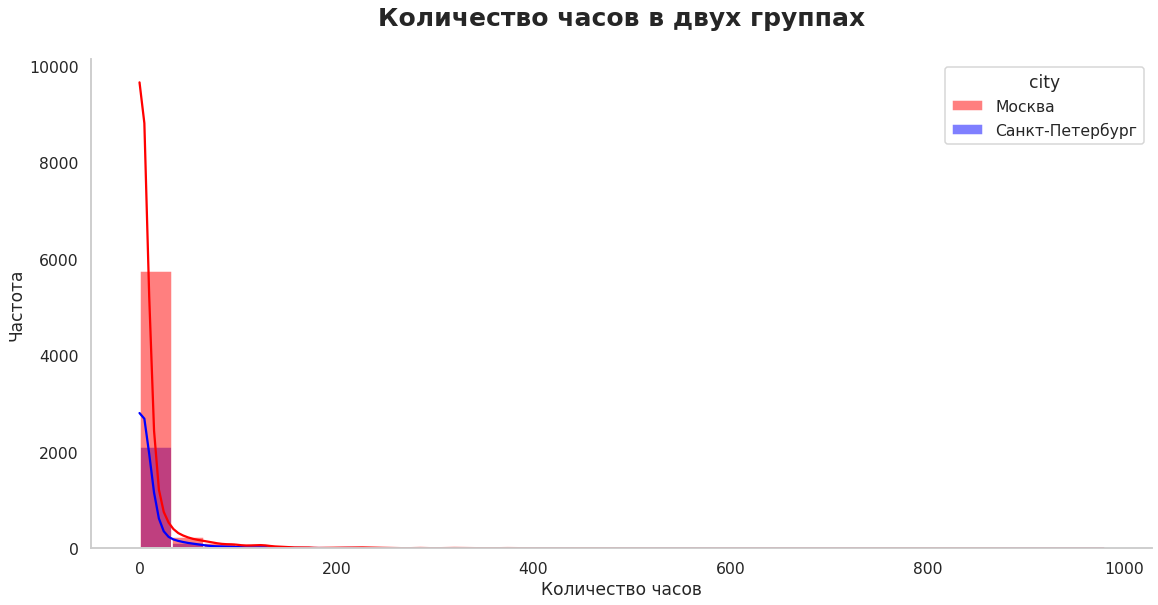

In [18]:
color_palette = {
    'Москва': 'red',   # Красный для группы "control"
    'Санкт-Петербург': 'blue',    # Синий для группы "test"
}


sns.histplot(data = df, x='hours', kde=True, bins=30, hue='city', palette=color_palette)

plt.xlabel('Количество часов')
plt.ylabel('Частота')
plt.title('Количество часов в двух группах\n', fontsize=25, fontweight="bold") #подпись определенного шрифта и с выделением
plt.grid(color='blue', alpha=0.1, linestyle='--') # сетка с указанием типа линии и ее прозрачности с цветом

sns.despine()

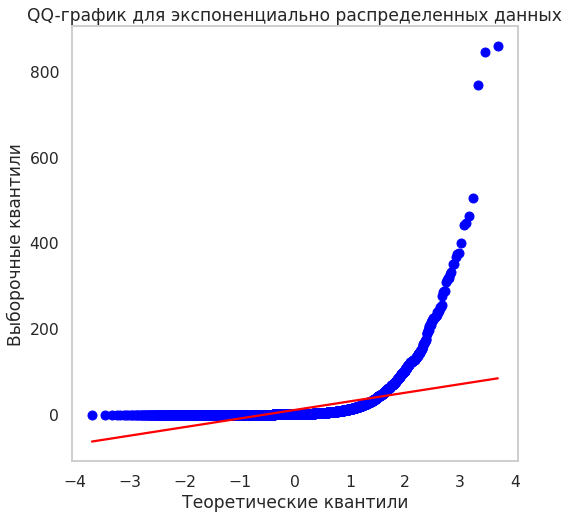

In [19]:
from scipy import stats
plt.figure(figsize=(8, 8))
stats.probplot(group_1, dist="norm", plot=plt)
plt.title('QQ-график для экспоненциально распределенных данных')
plt.xlabel('Теоретические квантили')
plt.ylabel('Выборочные квантили')
plt.grid()
plt.show()

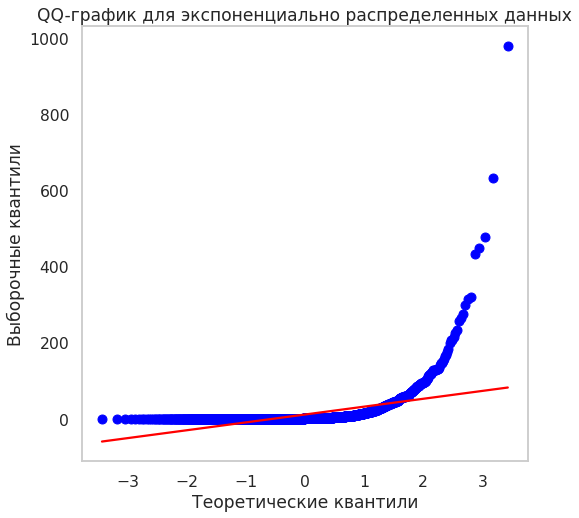

In [20]:
plt.figure(figsize=(8, 8))
stats.probplot(group_2, dist="norm", plot=plt)
plt.title('QQ-график для экспоненциально распределенных данных')
plt.xlabel('Теоретические квантили')
plt.ylabel('Выборочные квантили')
plt.grid()
plt.show()

##### Распределение не нормальное,поэтому применим тест Манна-Уитни.

In [21]:
from scipy.stats import mannwhitneyu
mw_test = mannwhitneyu(
    group_1, 
    group_2, 
    alternative='less') 
                            
                           
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах A и B различаются')

pvalue=0.6189600878052618 > 0.05
Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



  - Для проверки гипотезы о равенстве средних двух выборок используется тест Манна — Уитни. В качестве условия он не требует нормального распределения выборочного среднего. У теста Манна — Уитни таких требований нет, и он нечувствителен к выбросам из-за рангового преобразования.Обоснование выбора теста:   
  * тест Манна — Уитни нечувствителен к выбросам, его можно применять к любым числовым данным;  
  * T-тест сравнивает средние значения метрик, полученных по выборке, и благодаря этому его легко интерпретировать: в среднем метрика больше или меньше в одной из групп, или же средние равны;  
  * в данных встречаются сильные выбросы, которые нельзя просто удалить, и мы не хотим сравнивать средние значения.  
  
  - Уровень статистической значимости поставлен 0.05, для уменьшения риска ложноположительных результатов.   
  
  - Результат теста p-value > 0.05, соответственно опровергнуть нулевую гипотезу не получилось.    
  
  - Нулевая гипотеза,которая звучит так, что средняя активность пользователей из Москвы или Санкт-Петербурга равны и не отличаются друг от друга.  
  
  - Возможно, что средние значения часов прослушивания в обеих группах действительно равны, и нет значимой разницы в поведении пользователей.Либо могли присутствовать случайные факторы: езультаты могут быть подвержены случайным колебаниям, особенно если исследование проводилось в условиях, где много внешних факторов может влиять на поведение пользователей.    
  - Одной их рекомендаций является изучение данных более подробно: провести анализ подгрупп, чтобы выявить возможные скрытые различия.
  

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



## 2. Загрузите данные, оцените их целостность.


In [22]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [23]:
print(f'Количество дубликатов:{participants.duplicated().sum()}')
participants.head()

Количество дубликатов:0


,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [24]:

gr_A = participants[participants['group'] == 'A']['user_id']
gr_B = participants[participants['group'] == 'B']['user_id']

intersection = set(gr_A) & set(gr_B)
print(f'Количество пользователей,попавших в две группы:  {len(intersection)}') 

participants = participants[~participants['user_id'].isin(intersection)] 

p_group = participants.groupby('group')['user_id'].agg('count').reset_index()

print(f'Распределение количества пользователей в двух группах после удаления дубликатов: \n{p_group}')

Количество пользователей,попавших в две группы:  446
Распределение количества пользователей в двух группах после удаления дубликатов: 
  group  user_id
0     A     7684
1     B     5949


In [25]:
100 * participants[participants['group'] == 'A']['user_id'].nunique() / participants['user_id'].nunique(), 100 * participants[participants['group'] == 'B']['user_id'].nunique() / participants['user_id'].nunique()

(55.78380836870831, 44.21619163129169)

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [26]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [27]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [28]:
df_1 = participants.merge(events,on='user_id',how='left')
df_1.head()

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN


In [29]:
df_1['ab_test'].unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

##### В заданных параметрах теста название определено как `interface_eu_test`. В графе `ab_test` присутствует еще одно название,не относящееся к названию,соответственно данные пользователей,относящихся к другому тесту мы можем удалить.

In [30]:
rec_sys_test = df_1[df_1['ab_test'] == 'recommender_system_test']['user_id']
intersect = set(rec_sys_test)
df_1 = df_1[~df_1['user_id'].isin(intersect)]

In [31]:
df_1.groupby('group')['user_id'].agg('nunique').reset_index()

,group,user_id
0,A,4952
1,B,5011


In [32]:
100 * df_1[df_1['group'] == 'A']['user_id'].nunique() / df_1['user_id'].nunique(), 100 * df_1[df_1['group'] == 'B']['user_id'].nunique() / df_1['user_id'].nunique() 

(49.70390444645187, 50.29609555354813)

##### Распределение пользователей по группам корректно. Небольшое отклонение менее 1% можно оставить.

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [33]:
registration_times = df_1[df_1['event_name'] == 'registration'][['user_id', 'event_dt']]

df_1 = df_1.merge(registration_times, on='user_id', how='left')

df_1['day_reg'] = (df_1['event_dt_x'] - df_1['event_dt_y']).dt.days

df_1 = df_1[df_1['day_reg'] <= 7]

df_1.head()

,user_id,group,ab_test,device,event_dt_x,event_name,details,event_dt_y,day_reg
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [34]:
from statsmodels.stats.power import NormalIndPower

alpha = 0.05   
beta = 0.2 
power = 1 - beta  
p1 = 0.30  
p2 = 0.33 

p = (p1 + p2) / 2

effect_size = (p2 - p1) / np.sqrt(p * (1 - p))

power_analysis = NormalIndPower()

sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3763


##### Размер групп 4952 и 5011. При расчете необходимый размер выборки должен быть равен 3763. Размерность групп достаточна для получения статистически значимых результатов А/В теста.

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [35]:
grouped = df_1.groupby(['group', 'event_name'])['user_id'].nunique().reset_index()

df_pivot = grouped.pivot_table(index='group', columns='event_name', values='user_id', fill_value=0)


In [36]:
df_pivot['userses']= df_1['user_id'].nunique()
print(df_pivot[['registration','purchase','userses']])

event_name  registration  purchase  userses
group                                      
A                   4952      1435     9963
B                   5011      1562     9963


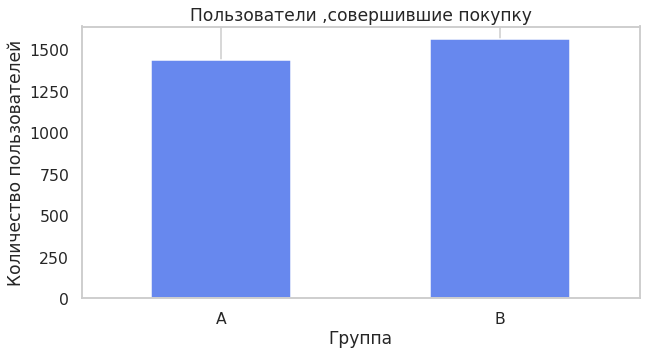

In [37]:

plt.figure(figsize=(10, 5))  
df_pivot['purchase'].plot(kind='bar')   
plt.title('Пользователи ,совершившие покупку')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y') 
plt.xticks(rotation=0)  
plt.show()  

In [38]:
df_pivot['conv'] = df_pivot['purchase']/df_pivot['userses']*100
df_pivot

event_name,login,product_cart,product_page,purchase,registration,userses,conv
group,,,,,,,
A,4952,1457,3155,1435,4952,9963,14.403292
B,5010,1398,3230,1562,5011,9963,15.678009


In [39]:
c = df_pivot.iloc[1]['conv']-df_pivot.iloc[0]['conv']
print(f'Конверсия увеличилась на {c:.2f} %')

Конверсия увеличилась на 1.27 %


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

##### По предварительным данным, мы видим рост пользователей в тестовой группе В,совершившим покупку в интернет-магазине.Возможно изменение интерфейса интернет-магазина положительно повлияло на динамику совершения покупки пользователями.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

In [40]:
df_pivot['convers'] = df_pivot['purchase']/df_pivot['registration']*100
df_pivot

event_name,login,product_cart,product_page,purchase,registration,userses,conv,convers
group,,,,,,,,
A,4952,1457,3155,1435,4952,9963,14.403292,28.978191
B,5010,1398,3230,1562,5011,9963,15.678009,31.171423


Нулевая гипотеза H₀: Конверсия в группе B не больше, чем в группе A + 3%.

Альтернативная гипотеза H₁: Конверсия в группе B больше, чем в группе A + 3%.

In [41]:
n_a= df_pivot.iloc[0]['registration'] 
n_b = df_pivot.iloc[1]['registration']
m_a = df_pivot.iloc[0]['purchase']
m_b = df_pivot.iloc[1]['purchase']
n_a,n_b,m_a,m_b

(4952.0, 5011.0, 1435.0, 1562.0)

In [42]:
from statsmodels.stats.proportion import proportions_ztest

n_a= df_pivot.iloc[0]['registration'] 
n_b = df_pivot.iloc[1]['registration']
m_a = df_pivot.iloc[0]['purchase']
m_b = df_pivot.iloc[1]['purchase']

conversion_a = (m_a / n_a) * 100
conversion_b = (m_b / n_b) * 100

print(f'Конверсия группы A: {conversion_a:.2f}%')
print(f'Конверсия группы B: {conversion_b:.2f}%')

alpha = 0.05 

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger' 
)
p_value_ztest


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')


Конверсия группы A: 28.98%
Конверсия группы B: 31.17%
pvalue=0.00850027205373803 < 0.05
Нулевая гипотеза не находит подтверждения!


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

### Вывод    
 В результате проведенного А/В теста делаем следующие выводы:   
 - В результате теста были задействованы 2 группы. Группы были независимы друг от друга и по количеству соизмеримы;   
 - Для измерения ожидаемого эффекта в измерении конверсии был использован z-тест;   
 - р-value равен ~0.0085,что меньше уровня статистической значимости;   
 - Нулевая гипотеза не находит подтверждения,что говорит о том,что упрощение интерфейса привело к увеличению конверсии в тестовой группе В, в сравнении с контрольной группе А;   
 - Конверсия в группе А = 28,98%, в группе В = 31,17%. Разница 2,19 %. 
 
